## Download the dataset

In [4]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://public.roboflow.com/..."
data_file = "./pothole.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path="potholeObjects/")
    print("done")
# delete zip file
os.remove(data_file)

extracting files...
done


In [3]:
!ls potholeObjects/

README.dataset.txt  README.roboflow.txt  test  train  valid


## Get the datastore from AML Workspace

In [1]:
import azureml.core

print("This notebook was created using version 1.35.0 of the Azure ML SDK.")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK.")
assert (
    azureml.core.VERSION >= "1.35"
), "Please upgrade the Azure ML SDK by running '!pip install --upgrade azureml-sdk' then restart the kernel."

This notebook was created using version 1.35.0 of the Azure ML SDK.
You are currently using version 1.37.0 of the Azure ML SDK.


In [18]:
!pip install --upgrade azureml-sdk

In [5]:
from azureml.core import Workspace

workspace = Workspace.from_config()
default_datastore = workspace.get_default_datastore()
datastore_name = default_datastore.name

## Convert from COCO to JSON Lines

In [5]:
#download coco2jsonl.py script from github https://github.com/Azure/azureml-examples/tree/1a41978d7ddc1d1f831236ff0c5c970b86727b44/python-sdk/tutorials/automl-with-azureml/image-object-detection
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/Azure/azureml-examples/1a41978d7ddc1d1f831236ff0c5c970b86727b44/python-sdk/tutorials/automl-with-azureml/image-object-detection/coco2jsonl.py

--2021-12-14 19:19:44--  https://raw.githubusercontent.com/Azure/azureml-examples/1a41978d7ddc1d1f831236ff0c5c970b86727b44/python-sdk/tutorials/automl-with-azureml/image-object-detection/coco2jsonl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4913 (4.8K) [text/plain]
Saving to: ‘coco2jsonl.py’

coco2jsonl.py       100%[===================>]   4.80K  --.-KB/s    in 0.02s   

2021-12-14 19:19:44 (314 KB/s) - ‘coco2jsonl.py’ saved [4913/4913]



In [6]:
# Generate training jsonl file from coco file
!python coco2jsonl.py \
--input_coco_file_path "./potholeObjects/train/_annotations.coco.json" \
--output_dir "./potholeObjects/train" --output_file_name "train_pothole_from_coco.jsonl" \
--task_type "ObjectDetection" \
--base_url "AmlDatastore://{datastore_name}/potholeObjects/train/"

Converting for ObjectDetection
Conversion completed. Converted 465 lines.


In [16]:
# Generate validation jsonl file from coco file
!python coco2jsonl.py \
--input_coco_file_path "./potholeObjects/valid/_annotations.coco.json" \
--output_dir "./potholeObjects/valid" --output_file_name "valid_pothole_from_coco.jsonl" \
--task_type "ObjectDetection" \
--base_url "AmlDatastore://{datastore_name}/potholeObjects/valid/"

Converting for ObjectDetection
Conversion completed. Converted 133 lines.


## Upload data to datastore

In [9]:
from azureml.core import Dataset
from azureml.data.datapath import DataPath
from azureml.data import DataType

# upload the training files to the Datastore
Dataset.File.upload_directory(
    src_dir="./potholeObjects/train/", target=DataPath(default_datastore, "/potholeObjects/train"), show_progress=True
)

Method upload_directory: This is an experimental method, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Validating arguments.
Arguments validated.
Uploading file to /potholeObjects/train
Uploading an estimated of 468 files
Uploaded 468 files
Creating new dataset


{
  "source": [
    "('workspaceblobstore', 'potholeObjects/train')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

In [17]:
# upload the validation files to the Datastore

Dataset.File.upload_directory(
    src_dir="./potholeObjects/valid/", target=DataPath(default_datastore, "/potholeObjects/valid"), show_progress=True
)

Validating arguments.
Arguments validated.
Uploading file to /potholeObjects/valid
Uploading an estimated of 135 files
Uploading ./potholeObjects/valid/valid_pothole_from_coco.jsonl
Uploaded ./potholeObjects/valid/valid_pothole_from_coco.jsonl, 1 files out of an estimated total of 2
Uploaded 1 files
Creating new dataset


{
  "source": [
    "('workspaceblobstore', 'potholeObjects/valid')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

## Create and register the datasets

In [12]:
training_dataset_name = "potholeObjectsTrainingDataset"

In [13]:
if training_dataset_name in workspace.datasets:
    training_dataset = workspace.datasets.get(training_dataset)
    print("Found the training dataset", training_dataset_name)
else:
    # create the Dataset
    training_dataset = Dataset.Tabular.from_json_lines_files(
            path=DataPath(default_datastore, "/potholeObjects/train/train_pothole_from_coco.jsonl"),
            set_column_types={"image_url": DataType.to_stream(default_datastore.workspace)},
    )

    # register the dataset in the Workspace
    training_dataset = training_dataset.register(
            workspace=workspace, name=training_dataset_name
    )

In [14]:
validation_dataset_name = "potholeObjectsValidationDataset"

In [18]:
if validation_dataset_name in workspace.datasets:
    validation_dataset = workspace.datasets.get(validation_dataset)
    print("Found the validation dataset", validation_dataset_name)
else:
    # create the Dataset
    validation_dataset = Dataset.Tabular.from_json_lines_files(
            path=DataPath(default_datastore, "/potholeObjects/valid/valid_pothole_from_coco.jsonl"),
            set_column_types={"image_url": DataType.to_stream(default_datastore.workspace)},
    )

    # register the dataset in the Workspace
    validation_dataset = validation_dataset.register(
            workspace=workspace, name=validation_dataset_name
    )

In [19]:
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Training dataset name: potholeObjectsTrainingDataset
Validation dataset name: potholeObjectsValidationDataset


## Run the experiment

In [9]:
from azureml.core import Experiment

experiment_name = "pothole-yolov5-model"
experiment = Experiment(workspace, name=experiment_name)

compute_target = workspace.compute_targets['gpu-computer'] #the name you gave to your computer instance

In [20]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

automl_config_yolov5 = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("yolov5")}),
    iterations=1,
)

In [21]:
automl_image_run = experiment.submit(automl_config_yolov5)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
pothole-yolov5-model,AutoML_042db030-ca9d-40ef-a4ab-732341d78f9e,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


## Visualize the predictions

In [34]:
# Register the model from the best run

best_child_run = automl_image_run.get_best_child()

model_name = best_child_run.properties["model_name"]
model_output_path = best_child_run.properties["model_output_path"]

model = best_child_run.register_model(
    model_name=model_name, model_path=model_output_path
)

In [36]:
model.download() #download model

'model.pt'

In [11]:
# downgrade azureml-sdk to work with azureml-contrib-automl-dnn-vision
!pip install azureml.automl.runtime==1.35.0

In [5]:
!pip install azureml-contrib-automl-dnn-vision

In [2]:
from azureml.contrib.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.contrib.automl.dnn.vision.object_detection_yolo.writers.score import _score_with_model

2021-12-15:12:59:51,615 INFO     [modeling_bert.py:226] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
2021-12-15:12:59:51,620 INFO     [modeling_xlnet.py:339] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [13]:
TASK_TYPE = 'image-object-detection'

model_settings = {"img_size": 640, "model_size": "medium", "box_score_thresh": 0.1, "box_iou_thresh": 0.5}
model_wrapper = load_model(TASK_TYPE, 'model.pt', **model_settings)

In [14]:
sample_image = "./img-23_jpg.rf.e6aa0daf83e72ccbf1ea10eb6a6ab3bd.jpg"

with open(sample_image, 'rb') as f:
    bytes_img = f.read()

In [15]:
model_response = run_inference(model_wrapper, bytes_img, _score_with_model)

pothole: [148.712, 547.218, 202.275, 144.16], 0.893
pothole: [166.205, 181.998, 466.793, 145.921], 0.865
pothole: [288.226, 137.167, 156.624, 45.879], 0.831
pothole: [0.773, 15.257, 61.238, 33.857], 0.772


<Figure size 1296x864 with 0 Axes>

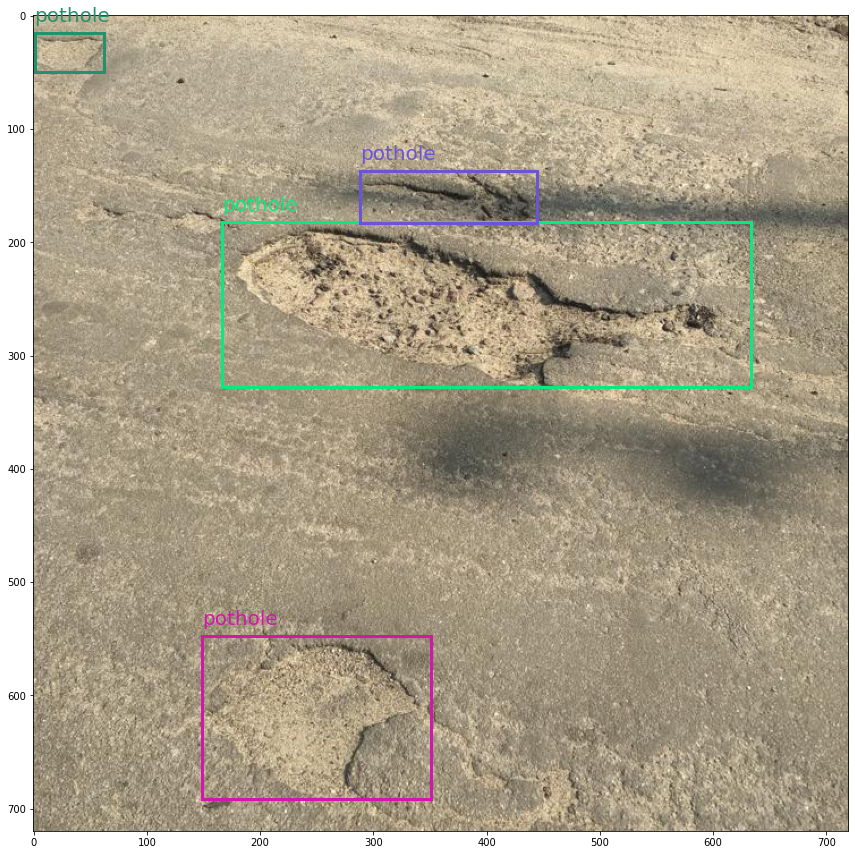

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection
detections = json.loads(model_response)
for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            "{}: [{}, {}, {}, {}], {}".format(
                detect["label"],
                round(topleft_x, 3),
                round(topleft_y, 3),
                round(width, 3),
                round(height, 3),
                round(conf_score, 3),
            )
        )

        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )

        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()